In [12]:
import pandas as pd
import numpy as np
import catboost as cb  # <-- 新增
from catboost import Pool # <-- 新增
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print("--- 库导入和环境设置完成 ---")
print("\n--- [阶段一] 开始数据加载与预处理 ---")

try:
    file_path = 'accepted_2007_to_2018q4.csv'
    df = pd.read_csv(file_path, low_memory=False)
    print(f"数据加载成功，原始数据形状: {df.shape}")
    df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
    start_date = pd.to_datetime('2007-01-01')
    end_date = pd.to_datetime('2014-12-31')
    df_filtered = df[(df['issue_d'] >= start_date) & (df['issue_d'] <= end_date)].copy()
    print(f"筛选2007-2014年数据后，形状为: {df_filtered.shape}")
    cols_to_drop = [
        'id', 'member_id', 'url', 'desc', 'title', 'emp_title', 'pymnt_plan', 'out_prncp',
        'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
        'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
        'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'acc_now_delinq',
        'chargeoff_within_12_mths', 'delinq_amnt', 'mths_since_last_delinq',
        'mths_since_last_record', 'mths_since_last_major_derog', 'hardship_flag',
        'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term',
        'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
        'hardship_length', 'hardship_dpd', 'hardship_loan_status',
        'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
        'hardship_last_payment_amount', 'debt_settlement_flag', 'debt_settlement_flag_date',
        'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage',
        'settlement_term', 'funded_amnt', 'funded_amnt_inv', 'initial_list_status',
        'verification_status_joint'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in df_filtered.columns]
    df_cleaned = df_filtered.drop(columns=existing_cols_to_drop, errors='ignore')
    print(f"剔除贷后及无关特征后，形状为: {df_cleaned.shape}")
    good_status = ['Fully Paid']
    bad_status = ['Charged Off', 'Default']
    df_model_data = df_cleaned[df_cleaned['loan_status'].isin(good_status + bad_status)].copy()
    df_model_data['Y'] = df_model_data['loan_status'].apply(lambda x: 0 if x in good_status else 1)
    df_model_data = df_model_data.drop(columns=['loan_status'])
    print(f"定义Y并筛选后，数据集形状: {df_model_data.shape}")
    final_df = df_model_data.copy()
    print(f"使用全部 {len(final_df)} 条数据进行OOT划分。")
    print("开始进行特征工程与格式转换...")
    if 'term' in final_df.columns: final_df['term'] = final_df['term'].str.extract('(\d+)').astype(float)
    if 'int_rate' in final_df.columns: final_df['int_rate'] = final_df['int_rate'].astype(float) / 100.0
    if 'revol_util' in final_df.columns: final_df['revol_util'] = final_df['revol_util'].astype(float) / 100.0
    emp_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6,
               '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
    if 'emp_length' in final_df.columns: final_df['emp_length'] = final_df['emp_length'].map(emp_map)
    if 'earliest_cr_line' in final_df.columns: final_df['earliest_cr_line'] = pd.to_datetime(
        final_df['earliest_cr_line'], errors='coerce')
    if 'issue_d' in final_df.columns: final_df['issue_d'] = pd.to_datetime(final_df['issue_d'], errors='coerce')
    if 'earliest_cr_line' in final_df.columns and 'issue_d' in final_df.columns:
        final_df['credit_history_months'] = ((final_df['issue_d'] - final_df['earliest_cr_line']).dt.days) / 30.0

    cols_to_remove_after_processing = ['earliest_cr_line', 'zip_code', 'addr_state', 'sub_grade',
                                       'emp_title']
    final_df = final_df.drop(columns=[col for col in cols_to_remove_after_processing if col in final_df.columns])

    print("开始处理缺失值...")
    cols_to_fill_999 = ['mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
                        'mths_since_recent_inq', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc', 'mo_sin_rcnt_tl']
    cols_to_fill_0 = ['il_util', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'open_acc_6m', 'open_act_il',
                      'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'total_bal_il',
                      'emp_length', 'pub_rec_bankruptcies', 'collections_12_mths_ex_med', 'mo_sin_old_il_acct',
                      'num_tl_120dp_2m', 'avg_cur_bal', 'mo_sin_old_rev_tl_op', 'num_actv_rev_tl', 'num_il_tl',
                      'num_op_rev_tl', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
                      'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl',
                      'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
                      'num_tl_op_past_12m', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
                      'total_il_high_credit_limit']
    cols_to_fill_median = ['dti', 'revol_util', 'credit_history_months', 'last_fico_range_high', 'last_fico_range_low',
                           'pct_tl_nvr_dlq', 'bc_open_to_buy', 'bc_util', 'percent_bc_gt_75']
    ALL_COLS_TO_KEEP = cols_to_fill_999 + cols_to_fill_0 + cols_to_fill_median
    missing_rates = final_df.isnull().sum() / len(final_df)
    high_missing_cols = missing_rates[missing_rates > 0.4].index.tolist()
    cols_to_actually_drop = [col for col in high_missing_cols if col not in ALL_COLS_TO_KEEP]
    if cols_to_actually_drop: final_df = final_df.drop(columns=cols_to_actually_drop)
    for col in cols_to_fill_999:
        if col in final_df.columns: final_df[col].fillna(999, inplace=True)
    for col in cols_to_fill_0:
        if col in final_df.columns: final_df[col].fillna(0, inplace=True)
    for col in cols_to_fill_median:
        if col in final_df.columns and final_df[col].isnull().any():
            median_val = final_df[col].median()
            final_df[col].fillna(median_val, inplace=True)
    print("缺失值填充完成。")
    print("开始处理异常值...")
    cols_for_strict_cap = ['annual_inc']
    cols_for_standard_cap = ['dti', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim',
                             'tot_hi_cred_lim', 'total_bal_ex_mort', 'avg_cur_bal']
    for col in cols_for_strict_cap:
        if col in final_df.columns:
            upper_bound = final_df[col].quantile(0.995)
            final_df[col] = np.clip(final_df[col], a_min=None, a_max=upper_bound)
    for col in cols_for_standard_cap:
        if col in final_df.columns:
            upper_bound = final_df[col].quantile(0.99)
            final_df[col] = np.clip(final_df[col], a_min=None, a_max=upper_bound)
    all_numeric_cols = final_df.select_dtypes(include=np.number).columns.tolist()
    if 'Y' in all_numeric_cols: all_numeric_cols.remove('Y')
    if 'issue_d' in all_numeric_cols: all_numeric_cols.remove('issue_d') # 排除 'issue_d'
    processed_cols = cols_for_strict_cap + cols_for_standard_cap
    remaining_numeric_cols = [col for col in all_numeric_cols if col not in processed_cols]
    for col in remaining_numeric_cols:
        lower_bound = final_df[col].quantile(0.01)
        upper_bound = final_df[col].quantile(0.99)
        final_df[col] = np.clip(final_df[col], lower_bound, upper_bound)
    print("异常值处理完成。")
    print(f"精简前原始形状: {final_df.shape}")
    cols_to_drop_manually = [
        'collections_12_mths_ex_med', 'policy_code', 'open_acc_6m', 'open_act_il',
        'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
        'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
        'total_cu_tl', 'inq_last_12m', 'num_tl_120dpd_2m', 'num_tl_30dpd',
        'fico_range_low', 'grade', 'last_fico_range_high', 'last_fico_range_low'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop_manually if col in final_df.columns]
    final_df_filtered = final_df.drop(columns=existing_cols_to_drop)
    print(f"手动移除了 {len(existing_cols_to_drop)} 个特征。")
    print(f"精简后形状 (准备OOT切分): {final_df_filtered.shape}")
except FileNotFoundError:
    print("--- [阶段一] 数据预处理全部完成 ---")

except FileNotFoundError:
    print("\n错误: 'accepted_2007_to_2018q4.csv' 未找到。请确保文件在脚本所在的目录中。")

--- 库导入和环境设置完成 ---

--- [阶段一] 开始数据加载与预处理 ---


KeyboardInterrupt: 

In [2]:
print("\n--- [阶段 2] 开始OOT (Out-of-Time) 切分 ---")
print("使用滚动时间窗口: 训练数据更接近测试数据，以对抗客群偏移")

train_df = final_df_filtered[
    (final_df_filtered['issue_d'] >= '2012-01-01') &
    (final_df_filtered['issue_d'] < '2013-07-01')
].copy()
val_df = final_df_filtered[
    (final_df_filtered['issue_d'] >= '2013-07-01') &
    (final_df_filtered['issue_d'] < '2014-01-01')
].copy()
test_df = final_df_filtered[
    (final_df_filtered['issue_d'] >= '2014-01-01') &
    (final_df_filtered['issue_d'] <= '2014-12-31')
].copy()
y_train = train_df['Y']
X_train = train_df.drop(columns=['Y', 'issue_d'])
y_val = val_df['Y']
X_val = val_df.drop(columns=['Y', 'issue_d'])
y_test = test_df['Y']
X_test = test_df.drop(columns=['Y', 'issue_d'])

print(f"训练集 (2012-2013H1): X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"验证集 (2013H2):     X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"测试集 (2014-OOT):   X_test:  {X_test.shape}, y_test:  {y_test.shape}")

if X_train.empty or X_val.empty or X_test.empty:
    print("\n*** 警告: 数据集为空！请检查日期筛选和切分逻辑！ ***")
    exit()


--- [阶段 2] 开始OOT (Out-of-Time) 切分 ---
使用滚动时间窗口: 训练数据更接近测试数据，以对抗客群偏移
训练集 (2012-2013H1): X_train: (106741, 57), y_train: (106741,)
验证集 (2013H2):     X_val:   (81430, 57), y_val:   (81430,)
测试集 (2014-OOT):   X_test:  (223103, 57), y_test:  (223103,)


In [3]:
print("\n--- [阶段 3] 开始特征工程 (衍生新特征) ---")

def create_stable_ratio_features(df):
    df_new = df.copy()
    df_new['annual_inc_safe'] = df_new['annual_inc'].replace(0, 0.01).fillna(0.01)
    df_new['credit_history_safe'] = df_new['credit_history_months'].replace(0, 0.01).fillna(0.01)
    df_new['loan_to_income_ratio'] = df_new['loan_amnt'] / df_new['annual_inc_safe']
    df_new['installment_to_income_ratio'] = df_new['installment'] / (df_new['annual_inc_safe'] / 12)
    df_new['monthly_debt'] = (df_new['dti'].fillna(0) * (df_new['annual_inc_safe'] / 12))
    df_new['delinq_to_history_ratio'] = df_new['delinq_2yrs'].fillna(0) / df_new['credit_history_safe']
    df_new['fico_x_dti'] = df_new['fico_range_high'].fillna(df_new['fico_range_high'].median()) * df_new['dti'].fillna(0)

    df_new = df_new.drop(columns=['annual_inc_safe', 'credit_history_safe'])
    return df_new

X_train = create_stable_ratio_features(X_train)
X_val = create_stable_ratio_features(X_val)
X_test = create_stable_ratio_features(X_test)
print(f"特征工程完成。 X_train 新形状: {X_train.shape}")


--- [阶段 3] 开始特征工程 (衍生新特征) ---
特征工程完成。 X_train 新形状: (106741, 62)


In [5]:
def calculate_psi(base_array, comparison_array, num_bins=10):
    # (PSI 函数定义同之前)
    try:
        base_array = pd.Series(base_array).replace([np.inf, -np.inf], np.nan).dropna()
        comparison_array = pd.Series(comparison_array).replace([np.inf, -np.inf], np.nan).dropna()
        if base_array.empty or comparison_array.empty: return np.nan

        bins = np.percentile(base_array, np.linspace(0, 100, num_bins + 1))
        bins = np.unique(bins)
        bins[0], bins[-1] = -np.inf, np.inf

        if len(bins) <= 2: return 0.0

        base_counts = pd.cut(base_array, bins=bins, right=False).value_counts(normalize=True)
        comp_counts = pd.cut(comparison_array, bins=bins, right=False).value_counts(normalize=True)

        psi_df = pd.DataFrame({'Base': base_counts, 'Comp': comp_counts}).fillna(0)
        psi_df['Base'] = psi_df['Base'].replace(0, 0.0001)
        psi_df['Comp'] = psi_df['Comp'].replace(0, 0.0001)

        psi_df['PSI'] = (psi_df['Comp'] - psi_df['Base']) * np.log(psi_df['Comp'] / psi_df['Base'])
        return psi_df['PSI'].sum()
    except Exception:
        return np.nan

# --- 【V2】两点锚定法评分函数 ---
def calculate_score_parameters_2pt(
    p1_prob=0.05, p1_score=800,  # 锚点1: 5%的违约率 -> 800分
    p2_prob=0.20, p2_score=600   # 锚点2: 20%的违约率 -> 600分
):
    odds1 = p1_prob / (1 - p1_prob)
    odds2 = p2_prob / (1 - p2_prob)
    log_odds1 = np.log(odds1)
    log_odds2 = np.log(odds2)

    Factor = (p1_score - p2_score) / (log_odds2 - log_odds1)
    Offset = p1_score + Factor * log_odds1

    print(f"\n应用“两点锚定法”参数：")
    print(f"  锚点1: P={p1_prob:.0%} -> Score={p1_score}")
    print(f"  锚点2: P={p2_prob:.0%} -> Score={p2_score}")
    print(f"  计算得到 Factor: {Factor:.4f}")
    print(f"  计算得到 Offset: {Offset:.4f}")
    return Offset, Factor

def convert_prob_to_score_2pt(prob, Offset, Factor):
    prob = np.clip(prob, 1e-7, 1 - 1e-7)
    odds = prob / (1 - prob)
    score = Offset - (Factor * np.log(odds))
    return score.astype(int)

print("\n--- [阶段 4] 辅助函数定义完成 (含两点锚定法) ---")


--- [阶段 4] 辅助函数定义完成 (含两点锚定法) ---


In [7]:

print("\n--- [阶段 5] CatBoost 模型准备、调优与训练 ---")
cols_to_drop_fix = ['application_type', 'disbursement_method']

X_train = X_train.drop(columns=cols_to_drop_fix, errors='ignore')
X_val = X_val.drop(columns=cols_to_drop_fix, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop_fix, errors='ignore')
print(f"【错误修复】: 已剔除残留的 'object' 列: {cols_to_drop_fix}")
CATEGORICAL_COLS = ['purpose', 'home_ownership', 'verification_status']
CATEGORICAL_COLS = [col for col in CATEGORICAL_COLS if col in X_train.columns]
print(f"识别到 {len(CATEGORICAL_COLS)} 个类别特征: {CATEGORICAL_COLS}")

BUSINESS_MONOTONICITY = {
    'loan_amnt': 1, 'term': 1, 'int_rate': 1, 'installment': 1,
    'emp_length': -1, 'fico_range_high': -1, 'annual_inc': -1, 'dti': 1,
    'revol_util': 1, 'delinq_2yrs': 1, 'pub_rec_bankruptcies': 1,
    'credit_history_months': -1, 'loan_to_income_ratio': 1,
    'installment_to_income_ratio': 1, 'monthly_debt': 1,
    'delinq_to_history_ratio': 1, 'fico_x_dti': 1
}
all_features = X_train.columns.tolist()
monotone_constraints_list = [BUSINESS_MONOTONICITY.get(f, 0) for f in all_features]
print("单调性约束列表已生成。")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"计算得到 scale_pos_weight: {scale_pos_weight:.4f}")
train_pool = Pool(X_train, y_train, cat_features=CATEGORICAL_COLS)
val_pool = Pool(X_val, y_val, cat_features=CATEGORICAL_COLS)
test_pool = Pool(X_test, cat_features=CATEGORICAL_COLS)
print("CatBoost Pool 对象创建完成。")
def objective_cb(trial):
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'CPU',
        'random_seed': 42,
        'logging_level': 'Silent',
        'scale_pos_weight': scale_pos_weight,
        'monotone_constraints': monotone_constraints_list,
        'iterations': 1000,
        'early_stopping_rounds': 50,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.9),
    }
    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=val_pool)

    return model.get_best_score()['validation']['AUC']

print("开始 Optuna 调优 (CatBoost)...")
study_cb = optuna.create_study(direction='maximize', study_name='cb_acard_oot')
study_cb.optimize(objective_cb, n_trials=30, show_progress_bar=True)
print(f"\n调优完成！最佳 Validation-AUC: {study_cb.best_value:.4f}")
print("找到的最佳超参数:", study_cb.best_params)
print("\n训练最终模型 (使用最佳参数)...")
final_cb_params = {
    'objective': 'Logloss', 'eval_metric': 'AUC',
    'task_type': 'CPU', 'random_seed': 42,
    'scale_pos_weight': scale_pos_weight,
    'monotone_constraints': monotone_constraints_list,
    'iterations': 2000,
    'early_stopping_rounds': 50
}
final_cb_params.update(study_cb.best_params)

model_cb_final = cb.CatBoostClassifier(**final_cb_params)

model_cb_final.fit(train_pool, eval_set=val_pool, verbose=100)

print("最终模型训练完成。")
print(f"最佳迭代次数为: {model_cb_final.get_best_iteration()}")

[I 2025-10-20 21:37:21,414] A new study created in memory with name: cb_acard_oot



--- [阶段 5] CatBoost 模型准备、调优与训练 ---
【错误修复】: 已剔除残留的 'object' 列: ['application_type', 'disbursement_method']
识别到 3 个类别特征: ['purpose', 'home_ownership', 'verification_status']
单调性约束列表已生成。
计算得到 scale_pos_weight: 5.2645
CatBoost Pool 对象创建完成。
开始 Optuna 调优 (CatBoost)...


Best trial: 0. Best value: 0.70108:   3%|▎         | 1/30 [00:07<03:31,  7.30s/it]

[I 2025-10-20 21:37:28,752] Trial 0 finished with value: 0.7010802886962755 and parameters: {'learning_rate': 0.06930559035684192, 'depth': 7, 'l2_leaf_reg': 1.1477930436410648, 'min_data_in_leaf': 76, 'colsample_bylevel': 0.8795186634006186}. Best is trial 0 with value: 0.7010802886962755.


Best trial: 1. Best value: 0.701997:   7%|▋         | 2/30 [00:29<07:27, 15.98s/it]

[I 2025-10-20 21:37:50,801] Trial 1 finished with value: 0.7019970364897354 and parameters: {'learning_rate': 0.017233422243470263, 'depth': 6, 'l2_leaf_reg': 1.5513805889300576, 'min_data_in_leaf': 21, 'colsample_bylevel': 0.7162247415163122}. Best is trial 1 with value: 0.7019970364897354.


Best trial: 2. Best value: 0.702257:  10%|█         | 3/30 [00:41<06:20, 14.08s/it]

[I 2025-10-20 21:38:02,631] Trial 2 finished with value: 0.7022567570111515 and parameters: {'learning_rate': 0.03956677816847501, 'depth': 7, 'l2_leaf_reg': 8.782700471291587, 'min_data_in_leaf': 64, 'colsample_bylevel': 0.6054158763811532}. Best is trial 2 with value: 0.7022567570111515.


Best trial: 2. Best value: 0.702257:  13%|█▎        | 4/30 [00:48<04:55, 11.37s/it]

[I 2025-10-20 21:38:09,840] Trial 3 finished with value: 0.7015339157202074 and parameters: {'learning_rate': 0.06814581700947021, 'depth': 7, 'l2_leaf_reg': 2.9608037575243102, 'min_data_in_leaf': 46, 'colsample_bylevel': 0.7201085394716791}. Best is trial 2 with value: 0.7022567570111515.


Best trial: 2. Best value: 0.702257:  17%|█▋        | 5/30 [01:06<05:44, 13.80s/it]

[I 2025-10-20 21:38:27,939] Trial 4 finished with value: 0.7016138155619165 and parameters: {'learning_rate': 0.015947815143063298, 'depth': 5, 'l2_leaf_reg': 1.2585026853842582, 'min_data_in_leaf': 70, 'colsample_bylevel': 0.6401557461684116}. Best is trial 2 with value: 0.7022567570111515.


Best trial: 2. Best value: 0.702257:  20%|██        | 6/30 [01:19<05:22, 13.43s/it]

[I 2025-10-20 21:38:40,662] Trial 5 finished with value: 0.7017376186541106 and parameters: {'learning_rate': 0.037116372091834174, 'depth': 6, 'l2_leaf_reg': 1.0514446315641595, 'min_data_in_leaf': 41, 'colsample_bylevel': 0.7639715521146275}. Best is trial 2 with value: 0.7022567570111515.


Best trial: 2. Best value: 0.702257:  23%|██▎       | 7/30 [01:28<04:34, 11.95s/it]

[I 2025-10-20 21:38:49,548] Trial 6 finished with value: 0.7013883307600111 and parameters: {'learning_rate': 0.061074706567563634, 'depth': 8, 'l2_leaf_reg': 7.003661519189177, 'min_data_in_leaf': 96, 'colsample_bylevel': 0.6365911652156208}. Best is trial 2 with value: 0.7022567570111515.


Best trial: 7. Best value: 0.702414:  27%|██▋       | 8/30 [01:40<04:27, 12.14s/it]

[I 2025-10-20 21:39:02,101] Trial 7 finished with value: 0.702413621908381 and parameters: {'learning_rate': 0.03681679701374581, 'depth': 5, 'l2_leaf_reg': 4.691036253101588, 'min_data_in_leaf': 41, 'colsample_bylevel': 0.8420678511383964}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  30%|███       | 9/30 [01:53<04:21, 12.43s/it]

[I 2025-10-20 21:39:15,173] Trial 8 finished with value: 0.7011882013598789 and parameters: {'learning_rate': 0.03564228803227871, 'depth': 7, 'l2_leaf_reg': 1.2157292566272584, 'min_data_in_leaf': 52, 'colsample_bylevel': 0.7911871482359847}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  33%|███▎      | 10/30 [02:16<05:11, 15.57s/it]

[I 2025-10-20 21:39:37,777] Trial 9 finished with value: 0.7007148088386908 and parameters: {'learning_rate': 0.010360361985215082, 'depth': 6, 'l2_leaf_reg': 1.365535625357261, 'min_data_in_leaf': 20, 'colsample_bylevel': 0.8053806184424871}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  37%|███▋      | 11/30 [02:33<05:03, 15.97s/it]

[I 2025-10-20 21:39:54,664] Trial 10 finished with value: 0.7018929378972807 and parameters: {'learning_rate': 0.02296471517804622, 'depth': 4, 'l2_leaf_reg': 4.598349623116634, 'min_data_in_leaf': 33, 'colsample_bylevel': 0.878083369992594}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  40%|████      | 12/30 [02:44<04:23, 14.63s/it]

[I 2025-10-20 21:40:06,235] Trial 11 finished with value: 0.7020571731359815 and parameters: {'learning_rate': 0.04574117197013881, 'depth': 4, 'l2_leaf_reg': 9.93925195841861, 'min_data_in_leaf': 65, 'colsample_bylevel': 0.6077847720488195}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  43%|████▎     | 13/30 [03:00<04:12, 14.87s/it]

[I 2025-10-20 21:40:21,650] Trial 12 finished with value: 0.7022746074165576 and parameters: {'learning_rate': 0.027818633874485042, 'depth': 5, 'l2_leaf_reg': 4.568498406126759, 'min_data_in_leaf': 85, 'colsample_bylevel': 0.6849113123819234}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  47%|████▋     | 14/30 [03:18<04:16, 16.02s/it]

[I 2025-10-20 21:40:40,331] Trial 13 finished with value: 0.7022465761803185 and parameters: {'learning_rate': 0.02487322352417859, 'depth': 5, 'l2_leaf_reg': 3.6850864576429814, 'min_data_in_leaf': 86, 'colsample_bylevel': 0.6863040118653345}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  50%|█████     | 15/30 [03:35<04:02, 16.17s/it]

[I 2025-10-20 21:40:56,840] Trial 14 finished with value: 0.7022105726837151 and parameters: {'learning_rate': 0.026136805469959896, 'depth': 5, 'l2_leaf_reg': 5.235478136230326, 'min_data_in_leaf': 95, 'colsample_bylevel': 0.8341931316848884}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  53%|█████▎    | 16/30 [03:40<03:00, 12.90s/it]

[I 2025-10-20 21:41:02,148] Trial 15 finished with value: 0.7017306258067058 and parameters: {'learning_rate': 0.09978034048946467, 'depth': 5, 'l2_leaf_reg': 2.6934813269253213, 'min_data_in_leaf': 55, 'colsample_bylevel': 0.680860935589186}. Best is trial 7 with value: 0.702413621908381.


Best trial: 7. Best value: 0.702414:  57%|█████▋    | 17/30 [03:56<03:00, 13.91s/it]

[I 2025-10-20 21:41:18,401] Trial 16 finished with value: 0.7010496783008799 and parameters: {'learning_rate': 0.017744931195572217, 'depth': 4, 'l2_leaf_reg': 2.213134286990052, 'min_data_in_leaf': 81, 'colsample_bylevel': 0.8371754962492693}. Best is trial 7 with value: 0.702413621908381.


Best trial: 17. Best value: 0.702426:  60%|██████    | 18/30 [04:07<02:33, 12.80s/it]

[I 2025-10-20 21:41:28,616] Trial 17 finished with value: 0.7024259203888561 and parameters: {'learning_rate': 0.05416198838883094, 'depth': 5, 'l2_leaf_reg': 5.743521494296708, 'min_data_in_leaf': 33, 'colsample_bylevel': 0.750266338921352}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  63%|██████▎   | 19/30 [04:15<02:05, 11.44s/it]

[I 2025-10-20 21:41:36,903] Trial 18 finished with value: 0.7015326152071121 and parameters: {'learning_rate': 0.051113001002665276, 'depth': 6, 'l2_leaf_reg': 6.416497129940379, 'min_data_in_leaf': 32, 'colsample_bylevel': 0.7599859542306916}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  67%|██████▋   | 20/30 [04:22<01:41, 10.11s/it]

[I 2025-10-20 21:41:43,902] Trial 19 finished with value: 0.7016017357517847 and parameters: {'learning_rate': 0.09802236875521345, 'depth': 4, 'l2_leaf_reg': 6.324009600136449, 'min_data_in_leaf': 33, 'colsample_bylevel': 0.8962781325168097}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  70%|███████   | 21/30 [04:34<01:37, 10.79s/it]

[I 2025-10-20 21:41:56,292] Trial 20 finished with value: 0.7024076809804181 and parameters: {'learning_rate': 0.05195021136168533, 'depth': 5, 'l2_leaf_reg': 1.9797655653506685, 'min_data_in_leaf': 42, 'colsample_bylevel': 0.8366460103060114}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  73%|███████▎  | 22/30 [04:42<01:19,  9.96s/it]

[I 2025-10-20 21:42:04,324] Trial 21 finished with value: 0.7020587026774892 and parameters: {'learning_rate': 0.052709123994266534, 'depth': 5, 'l2_leaf_reg': 2.042797094603046, 'min_data_in_leaf': 41, 'colsample_bylevel': 0.8428954957789024}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  77%|███████▋  | 23/30 [04:48<01:01,  8.79s/it]

[I 2025-10-20 21:42:10,378] Trial 22 finished with value: 0.7013898487925534 and parameters: {'learning_rate': 0.07793361225598498, 'depth': 5, 'l2_leaf_reg': 3.636712550312686, 'min_data_in_leaf': 28, 'colsample_bylevel': 0.8195372105479378}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  80%|████████  | 24/30 [04:57<00:53,  8.87s/it]

[I 2025-10-20 21:42:19,428] Trial 23 finished with value: 0.7014683330315126 and parameters: {'learning_rate': 0.04309953714397286, 'depth': 6, 'l2_leaf_reg': 1.8449703491788585, 'min_data_in_leaf': 46, 'colsample_bylevel': 0.7810480852351488}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  83%|████████▎ | 25/30 [05:14<00:55, 11.14s/it]

[I 2025-10-20 21:42:35,853] Trial 24 finished with value: 0.7023384338371254 and parameters: {'learning_rate': 0.03189395210067269, 'depth': 4, 'l2_leaf_reg': 2.5816685003951205, 'min_data_in_leaf': 41, 'colsample_bylevel': 0.8602329784252114}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  87%|████████▋ | 26/30 [05:23<00:41, 10.38s/it]

[I 2025-10-20 21:42:44,467] Trial 25 finished with value: 0.702264362135518 and parameters: {'learning_rate': 0.05354653473641637, 'depth': 5, 'l2_leaf_reg': 3.8575871104708126, 'min_data_in_leaf': 53, 'colsample_bylevel': 0.7341102714905788}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  90%|█████████ | 27/30 [05:28<00:26,  8.94s/it]

[I 2025-10-20 21:42:50,049] Trial 26 finished with value: 0.7008414454381775 and parameters: {'learning_rate': 0.08326694925794238, 'depth': 6, 'l2_leaf_reg': 5.081996941539898, 'min_data_in_leaf': 27, 'colsample_bylevel': 0.8053051800215673}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  93%|█████████▎| 28/30 [05:42<00:20, 10.33s/it]

[I 2025-10-20 21:43:03,622] Trial 27 finished with value: 0.7021493921743034 and parameters: {'learning_rate': 0.0323639980279154, 'depth': 5, 'l2_leaf_reg': 1.6724690929618324, 'min_data_in_leaf': 37, 'colsample_bylevel': 0.7791952084689437}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426:  97%|█████████▋| 29/30 [05:51<00:09,  9.98s/it]

[I 2025-10-20 21:43:12,775] Trial 28 finished with value: 0.7014861074777468 and parameters: {'learning_rate': 0.04747948433964777, 'depth': 4, 'l2_leaf_reg': 7.777497587878362, 'min_data_in_leaf': 47, 'colsample_bylevel': 0.8569849769916255}. Best is trial 17 with value: 0.7024259203888561.


Best trial: 17. Best value: 0.702426: 100%|██████████| 30/30 [06:00<00:00, 12.02s/it]


[I 2025-10-20 21:43:21,976] Trial 29 finished with value: 0.701809016823045 and parameters: {'learning_rate': 0.06199053175138214, 'depth': 6, 'l2_leaf_reg': 5.389077464035299, 'min_data_in_leaf': 57, 'colsample_bylevel': 0.8777527049393391}. Best is trial 17 with value: 0.7024259203888561.

调优完成！最佳 Validation-AUC: 0.7024
找到的最佳超参数: {'learning_rate': 0.05416198838883094, 'depth': 5, 'l2_leaf_reg': 5.743521494296708, 'min_data_in_leaf': 33, 'colsample_bylevel': 0.750266338921352}

训练最终模型 (使用最佳参数)...
0:	test: 0.6670972	best: 0.6670972 (0)	total: 16.3ms	remaining: 32.6s
100:	test: 0.6977703	best: 0.6977703 (100)	total: 1.86s	remaining: 35.1s
200:	test: 0.6999878	best: 0.6999878 (200)	total: 3.77s	remaining: 33.7s
300:	test: 0.7013827	best: 0.7013827 (300)	total: 5.69s	remaining: 32.1s
400:	test: 0.7020087	best: 0.7020345 (389)	total: 7.6s	remaining: 30.3s
500:	test: 0.7022649	best: 0.7024259 (486)	total: 9.51s	remaining: 28.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest

In [8]:
print("\n--- [阶段 6] 模型评估 (在 2014 OOT 测试集上) ---")

y_pred_proba_oot = model_cb_final.predict_proba(test_pool)[:, 1]

auc_score_oot = roc_auc_score(y_test, y_pred_proba_oot)
ks_stat_oot = ks_2samp(y_pred_proba_oot[y_test == 0], y_pred_proba_oot[y_test == 1]).statistic

print(f"OOT 测试集 ROC-AUC 评分: {auc_score_oot:.4f}")
print(f"OOT 测试集 KS 统计量: {ks_stat_oot:.4f}")


--- [阶段 6] 模型评估 (在 2014 OOT 测试集上) ---
OOT 测试集 ROC-AUC 评分: 0.7160
OOT 测试集 KS 统计量: 0.3162


In [10]:
print("\n--- [阶段 7] 计算 PSI (稳定性监控) ---")

y_pred_proba_train = model_cb_final.predict_proba(train_pool)[:, 1]
score_psi = calculate_psi(y_pred_proba_train, y_pred_proba_oot)
print(f"模型分 PSI (Train vs OOT): {score_psi:.4f}")
print("\n核心特征 PSI (Train vs OOT):")
feature_psi_results = {}
constrained_numeric_cols = [f for f in all_features if BUSINESS_MONOTONICITY.get(f, 0) != 0 and f not in CATEGORICAL_COLS]
for col in constrained_numeric_cols:
    feature_psi_results[col] = calculate_psi(X_train[col], X_test[col])

psi_series = pd.Series(feature_psi_results).sort_values(ascending=False)
print(psi_series.head(10))


--- [阶段 7] 计算 PSI (稳定性监控) ---
模型分 PSI (Train vs OOT): 0.0066

核心特征 PSI (Train vs OOT):
int_rate                   0.060418
fico_range_high            0.057190
credit_history_months      0.046659
revol_util                 0.038210
delinq_2yrs                0.029577
installment                0.022475
monthly_debt               0.018896
emp_length                 0.018067
delinq_to_history_ratio    0.017019
dti                        0.014411
dtype: float64


In [11]:
print("\n--- [阶段 8] 将概率转换为评分 (Scorecard) ---")
p_real = y_train.mean()
W = (p_real / (1 - p_real)) / (0.5 / (1 - 0.5))
y_prob_calibrated = (y_pred_proba_oot * W) / (1 - y_pred_proba_oot + y_pred_proba_oot * W)
print(f"概率校准完成 (真实坏账率 P_real={p_real:.1%})。")
offset, factor = calculate_score_parameters_2pt(
    p1_prob=0.05, p1_score=800,
    p2_prob=0.20, p2_score=600
)

scores_oot = convert_prob_to_score_2pt(y_prob_calibrated, offset, factor)

df_results = pd.DataFrame({
    'Actual_Y': y_test.values,
    'Prob_Model_Output': y_pred_proba_oot,
    'Prob_Calibrated': y_prob_calibrated,
    'Score': scores_oot
})

print("\n概率转换为评分示例 (OOT测试集前10条):")
print(df_results.head(10))

print("\n分数分布概览 (OOT测试集):")
print(df_results['Score'].describe())

print("\n好客户 (Y=0) 的分数分布 (OOT):")
print(df_results[df_results['Actual_Y'] == 0]['Score'].describe())

print("\n坏客户 (Y=1) 的分数分布 (OOT):")
print(df_results[df_results['Actual_Y'] == 1]['Score'].describe())

print("\n--- CatBoost 工业级A卡建模流程全部完成 ---")


--- [阶段 8] 将概率转换为评分 (Scorecard) ---
概率校准完成 (真实坏账率 P_real=16.0%)。

应用“两点锚定法”参数：
  锚点1: P=5% -> Score=800
  锚点2: P=20% -> Score=600
  计算得到 Factor: 128.3578
  计算得到 Offset: 422.0583

概率转换为评分示例 (OOT测试集前10条):
   Actual_Y  Prob_Model_Output  Prob_Calibrated  Score
0         1           0.284145         0.070111    753
1         0           0.506706         0.163261    631
2         0           0.451346         0.135144    660
3         1           0.539499         0.182029    614
4         0           0.610013         0.229061    577
5         0           0.420558         0.121162    676
6         1           0.547376         0.186804    610
7         0           0.305253         0.077030    740
8         1           0.623041         0.238938    570
9         0           0.340130         0.089179    720

分数分布概览 (OOT测试集):
count    223103.000000
mean        664.369991
std         102.661400
min         301.000000
25%         592.000000
50%         659.000000
75%         731.000000
max        1


--- [Stage 9] Starting Model Report Visualizations ---
Plotting data prepared.
Generating: Chart 1 - ROC Curve (OOT)


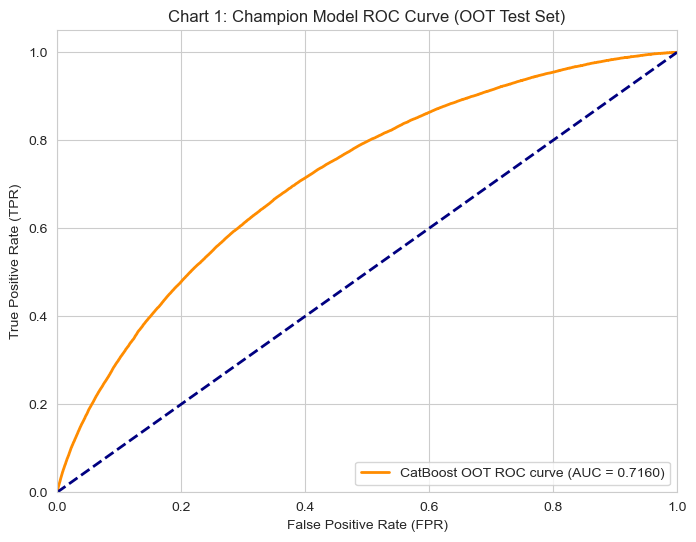

正在生成: 图表 2 - KS 曲线 (OOT) [最终修正版]


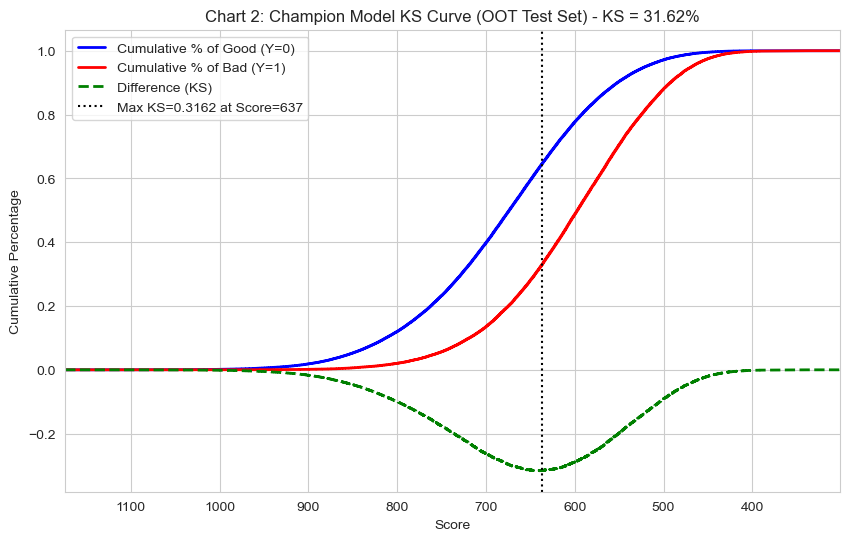

Generating: Chart 3 - Score Distribution (Good vs. Bad) (OOT)


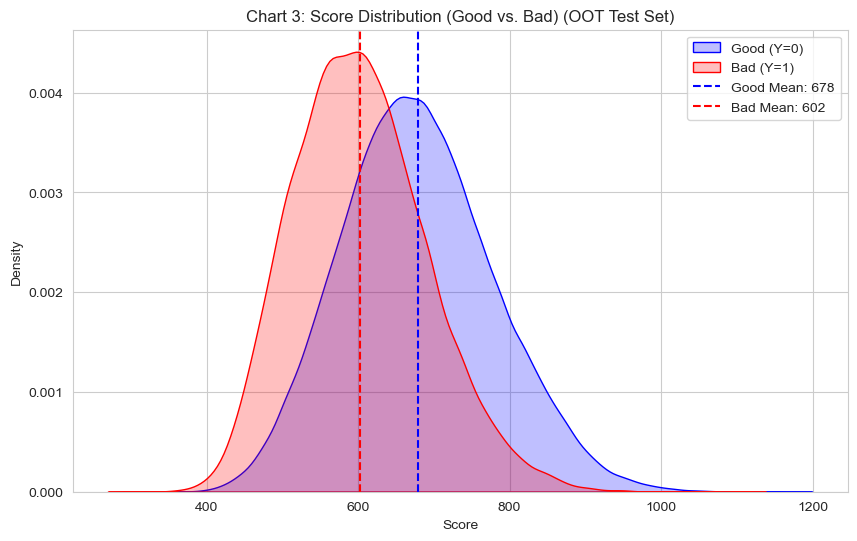

Generating: Chart 4 - Stability (PSI) Score Distribution


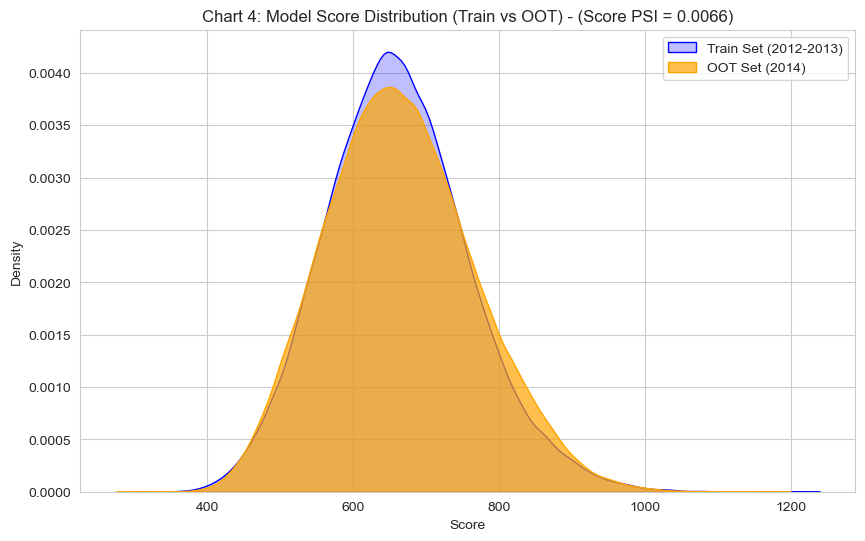

--- [Stage 9] Chart generation complete ---


In [16]:
# =============================================================================
# 9. [NEW] Model Report Visualizations
# =============================================================================
from sklearn.metrics import roc_auc_score, roc_curve
print("\n--- [Stage 9] Starting Model Report Visualizations ---")

# --- Prepare data ---
# We need OOT test data (already in df_results)
df_plot_oot = df_results.copy()

# We also need Training set scores for PSI comparison
# 1. Get training set probabilities (already calculated in [Stage 7])
# y_pred_proba_train = model_cb_final.predict_proba(train_pool)[:, 1]

# 2. Calibrate training set probabilities
p_real_train = y_train.mean()
W_train = (p_real_train / (1 - p_real_train)) / (0.5 / (1 - 0.5))
prob_calibrated_train = (y_pred_proba_train * W_train) / (1 - y_pred_proba_train + y_pred_proba_train * W_train)

# 3. Get training set scores (using the same offset and factor from [Stage 8])
# offset, factor = calculate_score_parameters_2pt(...)
scores_train = convert_prob_to_score_2pt(prob_calibrated_train, offset, factor)

df_plot_train = pd.DataFrame({
    'Actual_Y': y_train.values,
    'Score': scores_train
})

print("Plotting data prepared.")


# --- Chart 1: ROC Curve (OOT Test Set) ---
print("Generating: Chart 1 - ROC Curve (OOT)")
plt.figure(figsize=(8, 6))
# Use uncalibrated probabilities for AUC/ROC as it only cares about rank order
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_oot)
auc_val = roc_auc_score(y_test, y_pred_proba_oot)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CatBoost OOT ROC curve (AUC = {auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Chart 1: Champion Model ROC Curve (OOT Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 图表 2: KS 曲线 (OOT 测试集) [最终修正版] ---
print("正在生成: 图表 2 - KS 曲线 (OOT) [最终修正版]")

# 使用校准后的分数
df_plot_oot = df_results.copy()
y_actual = df_plot_oot['Actual_Y']
y_score = df_plot_oot['Score']

# 1. 将数据合并并排序
df_ks = pd.DataFrame({'Score': y_score, 'Bad': y_actual})
df_ks = df_ks.sort_values(by='Score', ascending=False) # 按分数从高到低排序

# 2. 计算好坏客户的总数
total_bad = df_ks['Bad'].sum()
total_good = len(df_ks) - total_bad

# 3. 计算累积百分比
df_ks['Good_Cumsum'] = (1 - df_ks['Bad']).cumsum() / total_good
df_ks['Bad_Cumsum'] = df_ks['Bad'].cumsum() / total_bad
df_ks['KS_Diff'] = df_ks['Bad_Cumsum'] - df_ks['Good_Cumsum']

# 4. 【修正】找到KS最大值 (使用绝对值 .abs())
ks_abs_diff = df_ks['KS_Diff'].abs()
ks_max_value = ks_abs_diff.max()        # <-- 修正: 使用 .abs().max()
ks_max_index = ks_abs_diff.idxmax()      # <-- 修正: 使用 .abs().idxmax()
ks_max_score = df_ks.loc[ks_max_index]['Score']

# 5. 为了绘图美观，添加 (0,0) 点
df_plot = pd.concat([
    pd.DataFrame({'Score': [df_ks['Score'].max() + 1], 'Bad_Cumsum': [0], 'Good_Cumsum': [0], 'KS_Diff': [0]}),
    df_ks
])

# --- 开始绘图 ---
plt.figure(figsize=(10, 6))
plt.plot(df_plot['Score'], df_plot['Good_Cumsum'], label='Cumulative % of Good (Y=0)', color='blue', lw=2)
plt.plot(df_plot['Score'], df_plot['Bad_Cumsum'], label='Cumulative % of Bad (Y=1)', color='red', lw=2)
plt.plot(df_plot['Score'], df_plot['KS_Diff'], label='Difference (KS)', color='green', lw=2, linestyle='--')

# 【修正】标记 KS 最大点 (使用修正后的变量)
plt.axvline(ks_max_score, color='black', linestyle=':',
            label=f'Max KS={ks_max_value:.4f} at Score={ks_max_score:.0f}')

# 【修正】标题 (使用修正后的变量)
plt.title(f'Chart 2: Champion Model KS Curve (OOT Test Set) - KS = {ks_max_value:.2%}')
plt.xlabel('Score')
plt.ylabel('Cumulative Percentage')

# 反转X轴，使得分低的在左边，分高的在右边
plt.xlim(df_plot['Score'].min(), df_plot['Score'].max())
plt.gca().invert_xaxis()

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# --- Chart 3: Score Distribution (Good vs. Bad) (OOT Test Set) ---
print("Generating: Chart 3 - Score Distribution (Good vs. Bad) (OOT)")
plt.figure(figsize=(10, 6))
sns.kdeplot(df_plot_oot[df_plot_oot['Actual_Y'] == 0]['Score'],
            label='Good (Y=0)', color='blue', fill=True)
sns.kdeplot(df_plot_oot[df_plot_oot['Actual_Y'] == 1]['Score'],
            label='Bad (Y=1)', color='red', fill=True)

# Mark mean values
mean_good = df_plot_oot[df_plot_oot['Actual_Y'] == 0]['Score'].mean()
mean_bad = df_plot_oot[df_plot_oot['Actual_Y'] == 1]['Score'].mean()
plt.axvline(mean_good, color='blue', linestyle='--', label=f'Good Mean: {mean_good:.0f}')
plt.axvline(mean_bad, color='red', linestyle='--', label=f'Bad Mean: {mean_bad:.0f}')

plt.title('Chart 3: Score Distribution (Good vs. Bad) (OOT Test Set)')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


# --- Chart 4: Model Stability (PSI) Score Distribution (Train vs OOT) ---
print("Generating: Chart 4 - Stability (PSI) Score Distribution")
plt.figure(figsize=(10, 6))
sns.kdeplot(scores_train, label=f'Train Set (2012-2013)',
            color='blue', fill=True)
sns.kdeplot(df_plot_oot['Score'], label=f'OOT Set (2014)',
            color='orange', fill=True, alpha=0.7)

plt.title(f'Chart 4: Model Score Distribution (Train vs OOT) - (Score PSI = {score_psi:.4f})')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

print("--- [Stage 9] Chart generation complete ---")